# **Prédiction de la consommation sur site**

## Introduction


Dans ce projet, nous nous concentrons sur la prédiction de la consommation énergétique des bâtiments à l'aide de divers algorithmes de régression. L'objectif principal est de démontrer les compétences en **création, entraînement et évaluation de modèles de machine learning supervisés**.

Nous allons explorer plusieurs modèles, notamment :

- **Dummy Regressor**
- **ElasticNet**
- **Support Vector Regression (SVR)**
- **Random Forest Regressor**
- **Gradient Boosting Regressor**

L'utilisation de plusieurs modèles permet de comparer leurs performances et de choisir le modèle le plus adapté à nos données spécifiques. Chaque modèle a ses propres avantages et limitations, et certains peuvent mieux capturer les relations complexes dans les données ou être plus robustes face aux anomalies. En testant divers modèles, nous pouvons également obtenir une meilleure compréhension des données et des facteurs influençant la consommation énergétique des bâtiments.

**L'analyse locale via SHAP** permet de comprendre l'influence de chaque variable sur les prédictions du modèle. En examinant des instances spécifiques, nous pouvons identifier des idées pour créer de nouvelles variables ou améliorer celles existantes, ce qui pourrait être exploité dans de futures itérations du modèle.

Par exemple, ici nous remarquons que les modèles sont moins précis pour certains types de bâtiments, ce qui suggère qu'il pourrait être utile de créer des variables supplémentaires spécifiques à ces types de bâtiments ou de segmenter davantage les données pour améliorer la précision des prédictions.

En explorant les erreurs de prédiction et en utilisant des outils comme SHAP pour l'explicabilité des modèles, nous pouvons obtenir des insights précieux pour affiner nos modèles et mieux comprendre les facteurs qui influencent la consommation énergétique des bâtiments. Cela nous permet également de communiquer plus efficacement les résultats et la fiabilité de nos modèles aux parties prenantes.  
   
P.S. L'utilisation de LIME n'apparaît pas dans ce notebook en raison de conflits d'installation dans l'environnement CONDA de LIME qui peuvent rendre le notebook illisible. Pour maintenir la lisibilité et la fluidité du notebook, nous avons opté pour SHAP comme outil principal d'explicabilité des modèles.

## **1. Importation des bibliothèques et des données**

Nous commençons par importer les bibliothèques nécessaires pour l'analyse et charger les données à partir d'un fichier CSV.

In [1]:
import sklearn
print(sklearn.__version__)

1.3.2


In [2]:
# Importation des bibliothèques
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


import sklearn
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, KFold, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.dummy import DummyRegressor
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.linear_model import ElasticNet
from sklearn.svm import SVR

from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor

from scipy.stats import uniform as sp_uniform
from scipy.stats import randint as sp_randint

# affichage de toutes les colonnes
pd.set_option('display.max_columns', None)


In [3]:
# chargement des données
data =  pd.read_csv('./2016_Building_Energy_FE.csv')
data.shape

(1548, 14)

In [4]:
data.columns

Index(['BuildingType', 'PrimaryPropertyType', 'YearBuilt', 'Neighborhood',
       'NumberofFloors', 'PropertyGFAParking', 'PropertyGFABuilding(s)',
       'ENERGYSTARScore_imputer', 'SiteEUIWN(kBtu/sf)',
       'GHGEmissionsIntensity', 'CategorieEnergie', 'LPUT', 'SLPUT',
       'ENERGYSTARScore'],
      dtype='object')

In [5]:
# affichage de ligne indexes 1139,349 et 103
data.iloc[[1139,349,103]]

,BuildingType,PrimaryPropertyType,YearBuilt,Neighborhood,NumberofFloors,PropertyGFAParking,PropertyGFABuilding(s),ENERGYSTARScore_imputer,SiteEUIWN(kBtu/sf),GHGEmissionsIntensity,CategorieEnergie,LPUT,SLPUT,ENERGYSTARScore
1139,NonResidential,Supermarket / Grocery Store,1986,northwest,1,0,45155,6.0,149.100006,3.51,Électricité & GazNaturel,High,High,6.0
349,NonResidential,Supermarket / Grocery Store,1980,north,1,0,58480,37.0,254.600006,4.66,Électricité & GazNaturel,High,High,37.0
103,NonResidential,Hospital,1953,northeast,10,0,879000,10.0,293.200012,9.27,GazNaturel & Électricité,High,High,10.0


In [6]:
df=data.iloc[[1139,349,103]]
# ajout de la colonne Log_conso
df['Log_conso']=df['SiteEUIWN(kBtu/sf)'].apply(lambda x: np.log1p(x))

# selection de colonne à afficher
df=df[['PrimaryPropertyType', 'YearBuilt','NumberofFloors','PropertyGFABuilding(s)','SiteEUIWN(kBtu/sf)',
        'CategorieEnergie', 'LPUT','ENERGYSTARScore', 'Log_conso']]
df

C:\Users\fathi\AppData\Local\Temp\ipykernel_16040\898612461.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Log_conso']=df['SiteEUIWN(kBtu/sf)'].apply(lambda x: np.log1p(x))


,PrimaryPropertyType,YearBuilt,NumberofFloors,PropertyGFABuilding(s),SiteEUIWN(kBtu/sf),CategorieEnergie,LPUT,ENERGYSTARScore,Log_conso
1139,Supermarket / Grocery Store,1986,1,45155,149.100006,Électricité & GazNaturel,High,6.0,5.011302
349,Supermarket / Grocery Store,1980,1,58480,254.600006,Électricité & GazNaturel,High,37.0,5.543614
103,Hospital,1953,10,879000,293.200012,GazNaturel & Électricité,High,10.0,5.684260


In [7]:
# on écarte ENERGYSTARScore dans un premier temps
#data = data.drop(['ENERGYSTARScore'], axis=1)

# suppression des valeurs manquantes
data = data.dropna()
data.shape

(996, 14)

## **2. Préparation des données**

### Définition des variables d'entrée et cibles
Nous définissons les variables d'entrée (features) et les variables cibles (target) que nous voulons prédire.

In [8]:
# Définition des variables d'entrée et cibles
X = data.drop(columns=['SiteEUIWN(kBtu/sf)','GHGEmissionsIntensity', 'ENERGYSTARScore'])
y = data[['SiteEUIWN(kBtu/sf)']]


### Division des données
Nous divisons les données en ensembles d'entraînement et de test pour valider nos modèles.

In [9]:

# Division des données en ensembles d'entraînement et de test pour chaque variable cible
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

# affichage des dimensions des données
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((796, 11), (200, 11), (796, 1), (200, 1))

### Encodage OneHot
Les variables catégorielles sont encodées en variables numériques à l'aide de l'encodage OneHot.

In [10]:
# 1. Encodage OneHot pour l'ensemble d'entraînement
onehot_encoder = OneHotEncoder(drop='first', sparse_output=False, handle_unknown='ignore')
cols=data.select_dtypes(include=['object']).columns

# Encodage OneHot pour l'ensemble d'entraînement
X_train_encoded = onehot_encoder.fit_transform(X_train[cols])
X_train_encoded_df = pd.DataFrame(X_train_encoded, columns=onehot_encoder.get_feature_names_out(cols), index=X_train.index)
X_train = pd.concat([X_train.drop(cols, axis=1), X_train_encoded_df], axis=1)

# Encodage OneHot pour l'ensemble de test
X_test_encoded = onehot_encoder.transform(X_test[cols])
X_test_encoded_df = pd.DataFrame(X_test_encoded, columns=onehot_encoder.get_feature_names_out(cols), index=X_test.index)
X_test = pd.concat([X_test.drop(cols, axis=1), X_test_encoded_df], axis=1)


c:\Users\fathi\anaconda3\envs\OCR\lib\site-packages\sklearn\preprocessing\_encoders.py:228: UserWarning: Found unknown categories in columns [1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


### Transformation logarithmique
Certaines variables sont transformées en utilisant la fonction logarithmique pour normaliser leur distribution.

In [11]:

# 3. Transformation des variables après la séparation
# Ajoutez les transformations logarithmiques ici pour X_train et X_test séparément
colslog = ['PropertyGFAParking', 'PropertyGFABuilding(s)']      
for col in colslog:
    X_train[col] = X_train[col].apply(lambda x: np.log1p(x))
    X_test[col] = X_test[col].apply(lambda x: np.log1p(x))


### Normalisation
Les variables numériques sont normalisées pour assurer que toutes les variables aient une échelle comparable.

In [12]:

# 4. Normalisation de la variable ENERGYSTARScore
scaler = StandardScaler()

X_train['ENERGYSTARScore_imputer'] = scaler.fit_transform(X_train[['ENERGYSTARScore_imputer']])
X_test['ENERGYSTARScore_imputer'] = scaler.transform(X_test[['ENERGYSTARScore_imputer']])
X_train['NumberofFloors'] = scaler.fit_transform(X_train[['NumberofFloors']])
X_test['NumberofFloors'] = scaler.transform(X_test[['NumberofFloors']])
X_train['YearBuilt'] = scaler.fit_transform(X_train[['YearBuilt']])
X_test['YearBuilt'] = scaler.transform(X_test[['YearBuilt']])
X_train['PropertyGFAParking'] = scaler.fit_transform(X_train[['PropertyGFAParking']])
X_test['PropertyGFAParking'] = scaler.transform(X_test[['PropertyGFAParking']])
X_train['PropertyGFABuilding(s)'] = scaler.fit_transform(X_train[['PropertyGFABuilding(s)']])
X_test['PropertyGFABuilding(s)'] = scaler.transform(X_test[['PropertyGFABuilding(s)']])

# Transformation de la variable cible pour l'ensemble d'entraînement
y_train_transformed = y_train.apply(lambda x: np.log1p(x))

## **3. Modèles de régression**

### 1. Dummy Regressor
Le modèle Dummy sert de base pour comparer les performances des autres modèles. Il utilise la moyenne des valeurs cibles comme prédiction.

In [13]:
# Création et entraînement du modèle dummy
dummy_regr = DummyRegressor(strategy="mean")
dummy_regr.fit(X_train, y_train_transformed)

# Prédictions sur l'ensemble de test
y_pred_dummy = dummy_regr.predict(X_test)
y_pred_dummy = pd.DataFrame(y_pred_dummy, index=y_test.index, columns=['GHGEmissionsIntensity_pred'])
y_pred_dummy = y_pred_dummy.apply(lambda x: np.expm1(x))

# Évaluation du modèle dummy
mse_dummy = mean_squared_error(y_test, y_pred_dummy)
r2_dummy = r2_score(y_test, y_pred_dummy)

print(f"RMSE du modèle dummy : {mse_dummy ** 0.5:.2f}")
print(f"Score R2 du modèle dummy : {r2_dummy:.2f}")


RMSE du modèle dummy : 57.23
Score R2 du modèle dummy : -0.03


### 2. ElasticNet

#### Construction et entraînement
ElasticNet est une combinaison de la régularisation L1 (lasso) et L2 (ridge). Nous entraînons le modèle avec les données préparées.

In [14]:
# Initialisation et entraînement du modèle ElasticNet pour les émissions de CO2
elastic_net = ElasticNet(random_state=0)
elastic_net.fit(X_train, y_train_transformed)

# Prédiction sur l'ensemble de test pour les émissions de CO2
y_pred_en = elastic_net.predict(X_test)

# transformation inverse de la prédiction pour les émissions de CO2
y_pred_en = np.expm1(y_pred_en) 

# Calcul des métriques pour les émissions de CO2
r2_en = r2_score(y_test, y_pred_en)
mae_en = mean_absolute_error(y_test, y_pred_en)
print(f"Score R2 du modèle ElasticNet : {r2_en:.2f}")
print(f"MAE du modèle ElasticNet : {mae_en:.2f}")

Score R2 du modèle ElasticNet : -0.03
MAE du modèle ElasticNet : 33.38


#### Optimisation des hyperparamètres
Nous utilisons GridSearchCV pour trouver les meilleurs hyperparamètres pour le modèle ElasticNet.

In [15]:
param_grid = {'alpha': np.logspace(-4, 0, 100),
                'l1_ratio': np.linspace(0, 1, 100)               
               }
# Création de l'objet GridSearchCV pour ElasticNet
grid_search_en = GridSearchCV(ElasticNet(random_state=0), param_grid, cv=4, scoring='r2', n_jobs=-1)

# Ajustement du modèle sur l'ensemble d'entraînement
grid_search_en.fit(X_train, y_train_transformed)

# Affichage des meilleurs paramètres et du meilleur score
best_parameters_en = grid_search_en.best_params_
print(f"Meilleurs paramètres pour CO2 : {best_parameters_en}")

# Évaluation du modèle sur l'ensemble de test avec les meilleurs paramètres trouvés
best_model_en = grid_search_en.best_estimator_
cv_scores = cross_val_score(best_model_en, X_train, y_train_transformed, cv=4, scoring='r2')
print("R^2 scores pour chaque fold sur les données transformées:", cv_scores)

# Prédiction sur l'ensemble de test avec les meilleurs paramètres trouvés
y_pred_best_EN = best_model_en.predict(X_test)
y_pred_best_EN = np.expm1(y_pred_best_EN)
y_pred_best_EN = pd.Series(y_pred_best_EN.ravel(), index=y_test.index)

test_score_en = r2_score(y_test, y_pred_best_EN)
mae_en = mean_absolute_error(y_test, y_pred_best_EN)
print(f"Score R2 sur l'ensemble de test avec les meilleurs paramètres : {test_score_en:.2f}")
print(f"MAE sur l'ensemble de test avec les meilleurs paramètres : {mae_en:.2f}")

Meilleurs paramètres pour CO2 : {'alpha': 0.002364489412645407, 'l1_ratio': 0.0}
R^2 scores pour chaque fold sur les données transformées: [0.65056252 0.57521455 0.52511885 0.60668386]
Score R2 sur l'ensemble de test avec les meilleurs paramètres : 0.67
MAE sur l'ensemble de test avec les meilleurs paramètres : 18.32


c:\Users\fathi\anaconda3\envs\OCR\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 9.195e+01, tolerance: 4.956e-02 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(
c:\Users\fathi\anaconda3\envs\OCR\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 6.774e+01, tolerance: 3.512e-02 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemente

#### Explication

Le modèle ElasticNet est un modèle de régression linéaire qui combine la régularisation L1 (lasso) et L2 (ridge). Les deux paramètres que nous cherchons à optimiser avec GridSearchCV pour le modèle ElasticNet sont `alpha` et `l1_ratio`.

Voici ce que chaque paramètre signifie :

1. **`alpha`** : C'est le paramètre de régularisation principal pour ElasticNet. Il contrôle la force de la régularisation. Un `alpha` plus élevé signifie une régularisation plus forte, ce qui peut aider à prévenir le surajustement (overfitting) mais peut aussi entraîner un sous-ajustement (underfitting) si la régularisation est trop forte. La régularisation agit en ajoutant une pénalité à la fonction de coût du modèle qui est proportionnelle à la taille des coefficients du modèle.

2. **`l1_ratio`** : Ce paramètre contrôle le compromis entre la régularisation L1 (lasso) et L2 (ridge). Un `l1_ratio` de 1.0 signifie que la régularisation est entièrement L1, tandis qu'un `l1_ratio` de 0 signifie que la régularisation est entièrement L2.
   - L1 (lasso) a tendance à produire des modèles avec moins de coefficients non nuls, ce qui peut être utile pour la sélection de caractéristiques ou lorsque vous pensez que seules quelques caractéristiques sont importantes.
   - L2 (ridge) pénalise les coefficients, mais ne les met pas à zéro, ce qui est utile lorsque vous pensez que de nombreuses caractéristiques contribuent un peu à la variable cible.

La `GridSearchCV` va essayer toutes les combinaisons possibles de `alpha` et `l1_ratio` dans les plages que vous avez définies pour trouver la combinaison qui donne le meilleur score (dans ce cas, le score R2) sur la validation croisée.

Voici comment vous pouvez jouer avec ces valeurs :
- Si vous constatez que le meilleur `alpha` est à l'une des extrémités de votre plage (par exemple, 0.001 ou 100), cela peut indiquer que vous devriez étendre la grille pour inclure des valeurs plus petites ou plus grandes.
- Pour le `l1_ratio`, si vous trouvez qu'il est proche de 1, cela pourrait signifier que le modèle bénéficie davantage d'une régularisation L1. Si c'est proche de 0, alors une régularisation L2 est peut-être préférable. Si c'est quelque part au milieu, cela indique que le modèle bénéficie d'une combinaison des deux types de régularisation.

### 3. Support Vector Regression (SVR)

#### Construction et entraînement
Le modèle SVR est entraîné avec des paramètres par défaut, puis optimisé à l'aide de GridSearchCV.

In [16]:
# Création d'un modèle SVR avec des paramètres par défaut
svr = SVR()

# Paramètres pour la validation croisée
param_grid = {'C': np.logspace(-3, 2, 6),
              'gamma': np.logspace(-3, 2, 6),
}

# Transformation de y_train pour l'utilisation dans GridSearchCV
y_train_transformed = np.log1p(y_train.values.ravel())

# Validation croisée pour trouver les meilleurs hyperparamètres
grid_search = GridSearchCV(svr, param_grid, cv=4, scoring='r2', verbose=1, n_jobs=-1)
grid_search.fit(X_train, y_train_transformed)

# Meilleurs paramètres et score
print(f"Meilleurs paramètres : {grid_search.best_params_}")

# Évaluation sur l'ensemble de test avec le meilleur estimateur
best_svr = grid_search.best_estimator_

# transformer y_train en vecteur 1D avant de calculer les scores CV
cv_scores = cross_val_score(best_svr, X_train, y_train_transformed, cv=4, scoring='r2')
print("R^2 scores for each fold:", cv_scores)

# Prédiction sur l'ensemble de test
y_pred_svr = best_svr.predict(X_test)

# Inversion de la transformation log1p
y_pred_svr = np.expm1(y_pred_svr)

# Conversion de y_pred_test en pd.Series pour correspondre à y_test
y_pred_svr = pd.Series(y_pred_svr, index=y_test.index)

# Calcul du score R2 et de l'erreur quadratique moyenne sur l'ensemble de test
test_r2 = r2_score(y_test, y_pred_svr)
test_maesvr = mean_absolute_error(y_test, y_pred_svr)

print(f"Score R2 sur l'ensemble de test avec les meilleurs paramètres : {test_r2}")
print(f"MAE sur l'ensemble de test avec les meilleurs paramètres : {test_maesvr}")

Fitting 4 folds for each of 36 candidates, totalling 144 fits


Meilleurs paramètres : {'C': 100.0, 'gamma': 0.01}
R^2 scores for each fold: [0.6681012  0.60940722 0.51865203 0.66639011]
Score R2 sur l'ensemble de test avec les meilleurs paramètres : 0.8098101769863504
MAE sur l'ensemble de test avec les meilleurs paramètres : 15.97274039695


#### Optimisation avec le kernel trick
Nous testons différents noyaux (linear, poly, rbf, sigmoid) pour améliorer les performances du modèle.

In [17]:
param_grid = {'kernel': ['linear', 'poly', 'rbf', 'sigmoid'],
    'C': [0.1, 1, 10],  # Pénalité de l'erreur
    'gamma': ['scale', 'auto'],  # Coefficient du noyau pour 'rbf', 'poly' et 'sigmoid'
    'degree': [2, 3, 4],  # Degré pour le noyau 'poly'
    'epsilon': [0.01, 0.1, 1],  # Marge d'erreur tolérée
}

# Nous devons créer un nouveau modèle SVR car nous allons tester différents noyaux
svr = SVR()

# Validation croisée pour trouver les meilleurs hyperparamètres
grid_search = GridSearchCV(svr, param_grid, cv=4, scoring='r2', verbose=1, n_jobs=-1)
grid_search.fit(X_train, y_train_transformed)

best_svr_kt = grid_search.best_estimator_
print(f"Meilleurs paramètres : {grid_search.best_params_}")

# score R2 pour chaque fold
cv_scores = cross_val_score(best_svr_kt, X_train, y_train_transformed, cv=4, scoring='r2')
print("R^2 scores for each fold:", cv_scores)

# prédiction sur l'ensemble de test
y_pred_svr_kt = best_svr_kt.predict(X_test)

# Inversion de la transformation log1p
y_pred_svr_kt = np.expm1(y_pred_svr_kt)

# Conversion de y_pred_test en pd.Series pour correspondre à y_test
y_pred_svr_kt = pd.Series(y_pred_svr_kt, index=y_test.index)

# Calcul du score R2 et de l'erreur quadratique moyenne sur l'ensemble de test
test_r2_svr_kt = r2_score(y_test, y_pred_svr_kt)
test_maesvr_kt = mean_absolute_error(y_test, y_pred_svr_kt)

print(f"Score R2 sur l'ensemble de test avec les meilleurs paramètres : {test_r2_svr_kt}")
print(f"MAE sur l'ensemble de test avec les meilleurs paramètres : {test_maesvr_kt}")

Fitting 4 folds for each of 216 candidates, totalling 864 fits
Meilleurs paramètres : {'C': 10, 'degree': 2, 'epsilon': 0.1, 'gamma': 'auto', 'kernel': 'rbf'}
R^2 scores for each fold: [0.64751224 0.6238998  0.51888577 0.67991332]
Score R2 sur l'ensemble de test avec les meilleurs paramètres : 0.8368210547511127
MAE sur l'ensemble de test avec les meilleurs paramètres : 14.89067889044468


#### Explication

Hyperparamètres pour Support Vector Regression (SVR)

Le modèle SVR possède plusieurs hyperparamètres qui contrôlent son comportement et sa performance. Voici une brève explication de chacun des hyperparamètres que nous avons considérés lors de la recherche par grille :

- `kernel`: Le type de noyau utilisé par le SVR. Un noyau transforme l'espace de caractéristiques de manière à ce que les données qui ne sont pas linéairement séparables dans l'espace d'origine puissent devenir séparables dans un espace de plus grande dimension. Les options incluent :
  - `linear`: Un noyau linéaire qui ne transforme pas l'espace de caractéristiques. Cela est utile lorsque les données sont supposées être linéairement séparables.
  - `poly`: Un noyau polynomial qui transforme l'espace de caractéristiques en un espace où les relations polynomiales sont linéairement séparables. Il dépend du degré du polynôme spécifié par l'hyperparamètre `degree`.
  - `rbf`: Un noyau de fonction de base radiale (Radial Basis Function) qui transforme l'espace de caractéristiques en un espace où les relations radiales sont linéairement séparables. Il est souvent utilisé pour des données qui ont des relations non linéaires complexes.
  - `sigmoid`: Un noyau qui transforme l'espace de caractéristiques de manière similaire à une fonction d'activation de neurone sigmoïde.

- `C`: Le paramètre de pénalité de l'erreur. Un C plus élevé encourage le modèle à classer toutes les formations correctement, au risque d'overfitting. Un C plus faible encourage la simplicité du modèle, au risque d'underfitting.

- `gamma`: Le coefficient pour les noyaux `poly`, `rbf`, et `sigmoid`. Un `gamma` élevé signifie que les points doivent être très proches les uns des autres pour être considérés dans la même classe, ce qui peut conduire à un overfitting. Un `gamma` bas signifie que les points peuvent être plus éloignés.

- `epsilon`: La marge d'erreur dans laquelle aucune pénalité n'est donnée aux erreurs. Un `epsilon` plus grand signifie que nous permettons une plus grande marge d'erreur entre les prédictions et les véritables valeurs.

- `degree`: C'est l'hyperparamètre du degré pour le noyau polynomial (`poly`). Il contrôle la flexibilité du modèle. Un degré plus élevé permet au modèle de se plier davantage pour capturer des relations plus complexes, mais augmente le risque d'overfitting.


### 4. Random Forest

#### Entraînement et optimisation
Le modèle RandomForest est entraîné et ses hyperparamètres sont optimisés à l'aide de GridSearchCV.

In [18]:
# Initialisation du modèle RandomForest
rf = RandomForestRegressor(random_state=42)

# Entraînement du modèle avec y_train_transformed
rf.fit(X_train, y_train_transformed.squeeze())

# Prédictions sur l'ensemble de test et inversion de la transformation
y_pred_transformed = rf.predict(X_test)
y_pred = np.expm1(y_pred_transformed)

# Conversion des prédictions en pd.Series en conservant l'index de y_test
y_pred_series = pd.Series(y_pred, index=y_test.index)

# Évaluation du modèle
print("Score R2 (sans optimisation) : ", r2_score(y_test, y_pred_series))
print("MAE (sans optimisation) : ", mean_absolute_error(y_test, y_pred_series))

# Optimisation des hyperparamètres avec GridSearchCV
param_grid = {
    'n_estimators': [50,100],
    'max_depth': [5,6,8],
    'min_samples_split': [3,7,8], 
    'min_samples_leaf': [6,7]
}

grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, cv=4, n_jobs=-1, scoring='r2')
grid_search.fit(X_train, y_train_transformed.squeeze())

# Affichage des meilleurs paramètres
print("Meilleurs paramètres : ", grid_search.best_params_)

# Évaluation du modèle optimisé
best_rf = grid_search.best_estimator_
y_pred_optimized_transformed = best_rf.predict(X_test)
y_pred_optimized_rf = np.expm1(y_pred_optimized_transformed)

# Conversion des prédictions en pd.Series en conservant l'index de y_test
y_pred_optimized_series_rf = pd.Series(y_pred_optimized_rf, index=y_test.index)

cv_scores = cross_val_score(best_rf, X_train, y_train_transformed.squeeze(), cv=4, scoring='r2')
print("R^2 scores for each fold:", cv_scores)

print("Score R2 (optimisé) : ", r2_score(y_test, y_pred_optimized_rf))
print("MAE (optimisé) : ", mean_absolute_error(y_test, y_pred_optimized_rf))

Score R2 (sans optimisation) :  0.78433439528579
MAE (sans optimisation) :  16.704182071774227
Meilleurs paramètres :  {'max_depth': 8, 'min_samples_leaf': 6, 'min_samples_split': 3, 'n_estimators': 100}
R^2 scores for each fold: [0.61462588 0.5673286  0.55247258 0.64801654]
Score R2 (optimisé) :  0.7808073348577347
MAE (optimisé) :  17.920394307749582


#### Explication :

Hyperparamètres courants pour le `RandomForestRegressor` de scikit-learn :

- **`n_estimators`** :
  - Indique le nombre d'arbres dans la forêt. Chaque arbre contribue à la prédiction finale, et plus il y a d'arbres, plus le modèle est stable et robuste. Cependant, un nombre trop élevé d'arbres peut augmenter inutilement le temps de calcul sans apporter une amélioration significative de la performance.

- **`max_depth`** :
  - Profondeur maximale des arbres. Si elle n'est pas définie, les arbres sont développés jusqu'à ce que toutes les feuilles soient pures ou contiennent moins d'échantillons que `min_samples_split`. Une profondeur plus grande permet de capturer plus de détails des données, mais augmente le risque de surajustement.

- **`min_samples_split`** :
  - Le nombre minimum d'échantillons requis pour diviser un nœud interne. Des valeurs plus élevées empêchent la création de nœuds qui ne représentent que peu d'échantillons, ce qui peut aider à la généralisation.

- **`min_samples_leaf`** :
  - Le nombre minimum d'échantillons requis pour être à un nœud feuille. Comme `min_samples_split`, cela ajoute une contrainte sur la taille de l'arbre et peut réduire le surajustement en empêchant l'apprentissage de bruit dans les données.

- **`max_features`** :
  - Le nombre de caractéristiques à considérer lors de la recherche de la meilleure division. Si ‘auto’, alors `max_features=sqrt(n_features)`. Si ‘sqrt’, alors `max_features` est égal à la racine carrée du nombre total de caractéristiques. La réduction du nombre de caractéristiques peut augmenter la diversité entre les arbres et améliorer la généralisation.

- **`bootstrap`** :
  - Méthode utilisée pour échantillonner les données lors de la construction des arbres. Si True, l'ensemble des données est échantillonné avec remplacement. Si False, l'ensemble des données est utilisé pour construire chaque arbre.

- **`oob_score`** :
  - Si True, utilise les échantillons out-of-bag pour estimer le R2 sur les données d'apprentissage. Cela peut être utilisé comme une alternative à la validation croisée.

- **`random_state`** :
  - Contrôle la reproductibilité des résultats en définissant une graine pour le générateur de nombres aléatoires utilisé lors de la sélection des caractéristiques et des échantillons bootstrap.

Les hyperparamètres sont essentiels pour contrôler le processus d'apprentissage. Un bon réglage peut considérablement améliorer les performances du modèle, tandis qu'un mauvais réglage peut entraîner un surajustement ou un sous-ajustement. La sélection des hyperparamètres doit souvent être guidée par la validation croisée pour s'assurer que les paramètres choisis fonctionnent bien sur des données non vues.

### 5. Gradient Boosting

#### Entraînement et optimisation
Le modèle GradientBoosting est entraîné et optimisé avec GridSearchCV pour améliorer ses performances.

In [19]:
# Initialisation du modèle GradientBoostingRegressor
gbr = GradientBoostingRegressor(random_state=42)

# Entraînement du modèle avec les paramètres par défaut pour voir les performances de base
gbr.fit(X_train, y_train_transformed)

# Prédictions sur l'ensemble de test avec le modèle de base
y_pred_gbr = gbr.predict(X_test)
y_pred_gbr = np.expm1(y_pred_gbr)

# Évaluation des prédictions de base
print("Score R2 (Gradient Boosting sans optimisation) : ", r2_score(y_test, y_pred_gbr))
print("MAE (Gradient Boosting sans optimisation) : ", mean_absolute_error(y_test, y_pred_gbr))

Score R2 (Gradient Boosting sans optimisation) :  0.7611606878485819
MAE (Gradient Boosting sans optimisation) :  16.68769112720053


In [20]:
# Gradient Boosting Regressor
gb = GradientBoostingRegressor(random_state=42)

# Hyperparamètres à tester
param_grid = {
    'n_estimators': [155, 160 , 165],
    'max_depth': [4, 6],
    'min_samples_split': [4,6],
    'min_samples_leaf': [1, 2],
    'learning_rate': [0.07, 0.08, 0.09],
    'max_features': ['sqrt']
}

# Initialisation du GridSearchCV
grid_search_gb = GridSearchCV(estimator=gb, param_grid=param_grid, cv=4, n_jobs=-1, scoring='r2')

# Entraînement du modèle
grid_search_gb.fit(X_train, y_train_transformed.squeeze())

# Affichage des meilleurs paramètres
print("Meilleurs paramètres : ", grid_search_gb.best_params_)

# Évaluation du modèle optimisé
best_gb = grid_search_gb.best_estimator_
print("Score R2 pour chaque fold:", cross_val_score(best_gb, X_train, y_train_transformed.squeeze(), cv=4, scoring='r2'))

y_pred_optimized_gb = best_gb.predict(X_test)
y_pred_optimized_gb = np.expm1(y_pred_optimized_gb)
y_pred_optimized_gb = pd.Series(y_pred_optimized_gb.ravel(), index=y_test.index)

print("Score R2 (Gradient Boosting optimisé) : ", r2_score(y_test, y_pred_optimized_gb))
print("MAE (Gradient Boosting optimisé) : ", mean_absolute_error(y_test, y_pred_optimized_gb))

Meilleurs paramètres :  {'learning_rate': 0.09, 'max_depth': 4, 'max_features': 'sqrt', 'min_samples_leaf': 2, 'min_samples_split': 6, 'n_estimators': 165}
Score R2 pour chaque fold: [0.6871993  0.60149153 0.54700427 0.64653666]
Score R2 (Gradient Boosting optimisé) :  0.7709654183277094
MAE (Gradient Boosting optimisé) :  17.375087398328166


#### Explication :

hyperparamètres les plus courants pour le `GradientBoostingRegressor` de scikit-learn :

- **`n_estimators`** : 
  - Cela représente le nombre d'étapes de boosting à effectuer. Chaque étape ajoute un nouvel arbre de régression faible à la prédiction. Plus il y a d'arbres, plus le modèle peut être complexe. Cependant, un nombre trop élevé peut conduire à un surajustement.

- **`learning_rate`** :
  - Il s'agit d'un facteur qui réduit la contribution de chaque arbre à la prédiction finale. Un taux d'apprentissage plus faible nécessite un plus grand nombre d'arbres de boosting (n_estimators) mais peut améliorer la performance du modèle et sa généralisation.

- **`max_depth`** :
  - La profondeur maximale de chaque arbre de régression. Cela contrôle la complexité de chaque arbre. Une valeur plus élevée permet aux arbres de capturer des relations plus complexes dans les données, mais augmente également le risque de surajustement.

- **`min_samples_split`** :
  - Le nombre minimal d'échantillons requis pour diviser un nœud interne. Une valeur plus élevée empêche la création d'arbres trop complexes, ce qui peut aider à éviter le surajustement.

- **`min_samples_leaf`** :
  - Le nombre minimal d'échantillons qu'un nœud feuille doit avoir. Comme pour `min_samples_split`, une valeur plus élevée empêche l'apprentissage de modèles trop complexes.

- **`subsample`** :
  - La fraction des échantillons à utiliser pour ajuster les arbres de boosting individuels. Si inférieure à 1, cela ajoute du sous-échantillonnage, ce qui peut augmenter la robustesse du modèle en introduisant davantage de variance entre les arbres individuels (technique connue sous le nom de Stochastic Gradient Boosting).

- **`max_features`** :
  - Le nombre de features à considérer lors de la recherche de la meilleure division à chaque nœud. Cela peut également aider à améliorer la généralisation du modèle en empêchant les arbres de devenir trop dépendants de certaines features.

- **`loss`** (non inclus dans le code initial) :
  - La fonction de perte à optimiser. `ls` est la somme des carrés des erreurs et est bonne pour la plupart des cas. `lad` (moindre valeur absolue des écarts) est moins sensible aux anomalies. `huber` est une combinaison des deux et est souvent utilisée lorsque les données contiennent des anomalies.

Chaque hyperparamètre a un impact sur la manière dont le modèle apprend des données. L'ajustement de ces hyperparamètres est crucial pour trouver le bon équilibre entre la capacité de capture de la complexité des données (biais) et la capacité du modèle à être généralisé à des données non vues (variance).

## **4. Visualisation des résultats et importance des variables**

### Valeurs réelles et prédites
Nous visualisons les valeurs réelles versus les valeurs prédites pour chaque modèle afin d'évaluer leur performance.

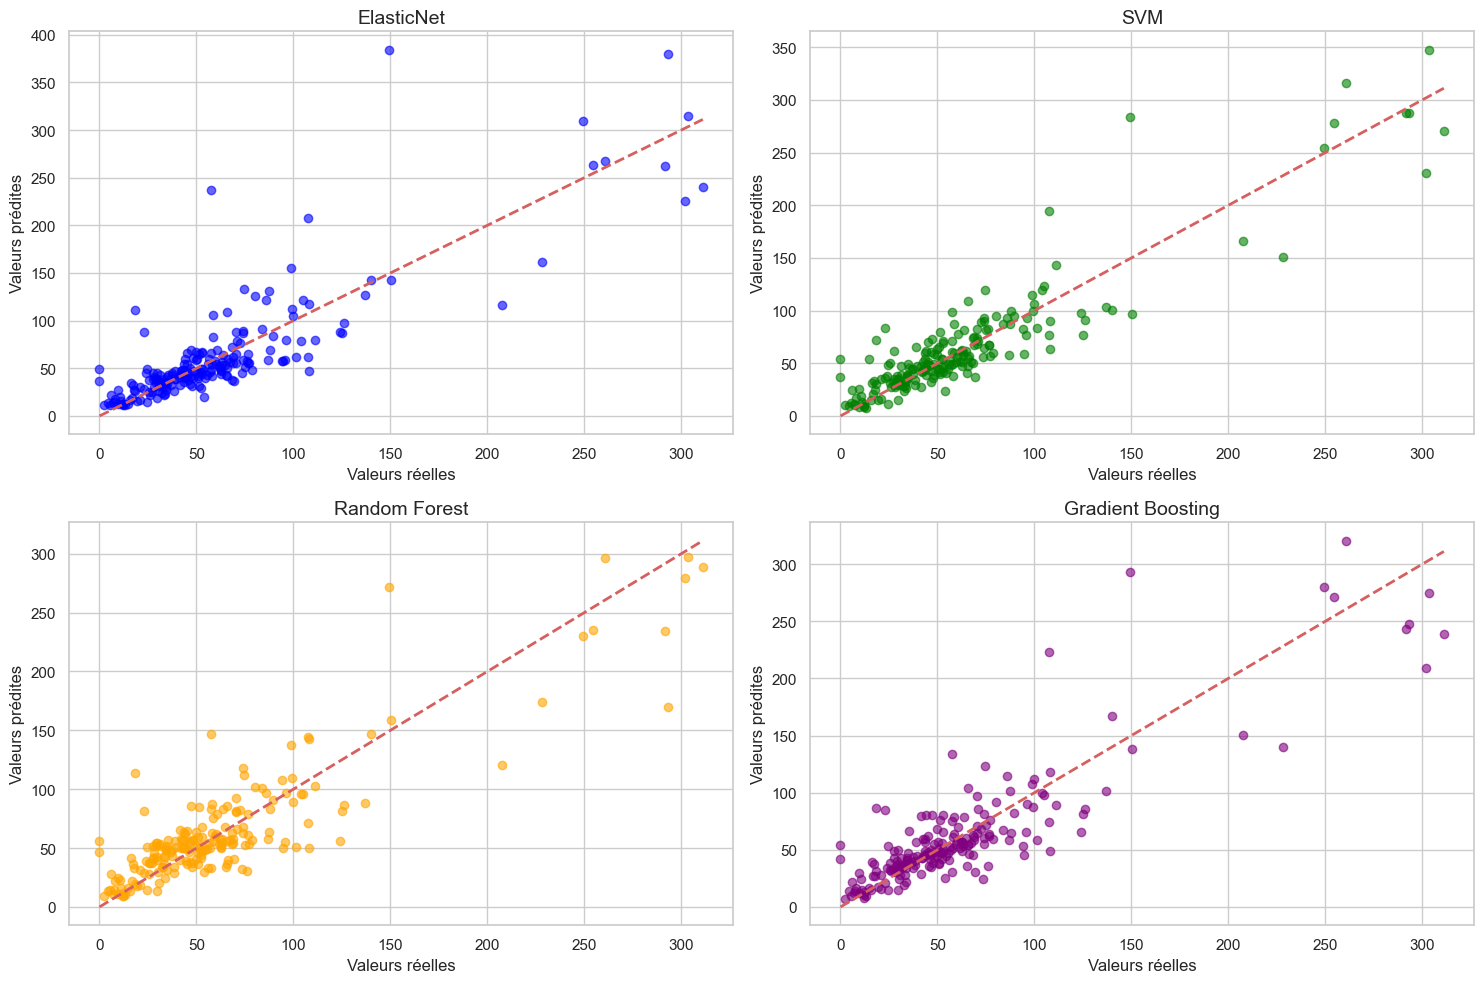

In [21]:
# Configuration du style
sns.set(style='whitegrid', palette='muted')

# Définition de la taille de la police pour les graphiques
plt.rc('axes', titlesize=14)     # Taille de la police pour les titres
plt.rc('axes', labelsize=12)     # Taille de la police pour les axes x et y
plt.rc('legend', fontsize=11)    # Taille de la police pour la légende

# Création d'une figure avec plusieurs subplots
fig, axs = plt.subplots(2, 2, figsize=(15, 10))

# Affichage du premier subplot pour ElasticNet
axs[0, 0].scatter(y_test, y_pred_best_EN, alpha=0.6, color='blue', label='ElasticNet')
axs[0, 0].plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], '--r', linewidth=2)
axs[0, 0].set_title('ElasticNet')
axs[0, 0].set_xlabel('Valeurs réelles')
axs[0, 0].set_ylabel('Valeurs prédites')

# Affichage du deuxième subplot pour SVM
axs[0, 1].scatter(y_test, y_pred_svr_kt, alpha=0.6, color='green', label='SVM')
axs[0, 1].plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], '--r', linewidth=2)
axs[0, 1].set_title('SVM')
axs[0, 1].set_xlabel('Valeurs réelles')
axs[0, 1].set_ylabel('Valeurs prédites')

# Affichage du troisième subplot pour Random Forest
axs[1, 0].scatter(y_test, y_pred_optimized_rf, alpha=0.6, color='orange', label='Random Forest')
axs[1, 0].plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], '--r', linewidth=2)
axs[1, 0].set_title('Random Forest')
axs[1, 0].set_xlabel('Valeurs réelles')
axs[1, 0].set_ylabel('Valeurs prédites')

# Affichage du quatrième subplot pour Gradient Boosting
axs[1, 1].scatter(y_test, y_pred_optimized_gb, alpha=0.6, color='purple', label='Gradient Boosting')
axs[1, 1].plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], '--r', linewidth=2)
axs[1, 1].set_title('Gradient Boosting')
axs[1, 1].set_xlabel('Valeurs réelles')
axs[1, 1].set_ylabel('Valeurs prédites')

# Ajustement des marges entre les graphiques
plt.tight_layout()

# Affichage de la figure finale
plt.show()

### Distribution des erreurs
Nous analysons la distribution des résidus (erreurs) pour chaque modèle afin de comprendre la précision de leurs prédictions.

c:\Users\fathi\anaconda3\envs\OCR\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\fathi\anaconda3\envs\OCR\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\fathi\anaconda3\envs\OCR\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\fathi\anaconda3\envs\OCR\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN 

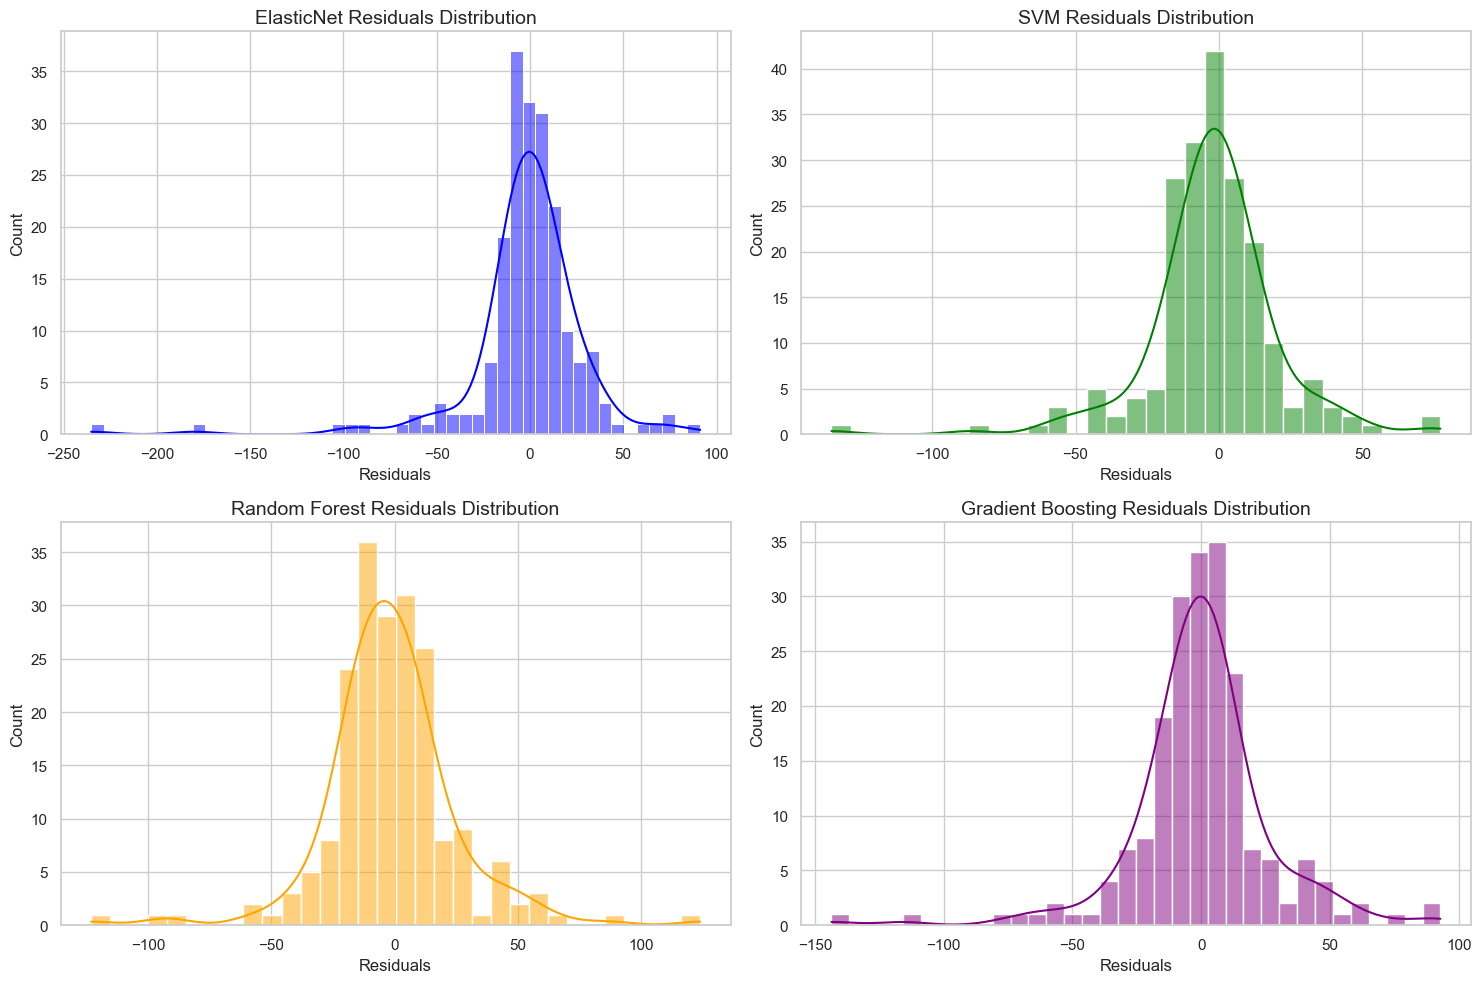

In [22]:
residus_en = y_test['SiteEUIWN(kBtu/sf)']  - y_pred_best_EN
residus_svr = y_test['SiteEUIWN(kBtu/sf)']  - y_pred_svr_kt
residus_rf = y_test['SiteEUIWN(kBtu/sf)']  - y_pred_optimized_rf
residus_gb = y_test['SiteEUIWN(kBtu/sf)']  - y_pred_optimized_gb

# Création d'une figure avec plusieurs subplots
fig, axs = plt.subplots(2, 2, figsize=(15, 10))

# Affichage du premier subplot pour ElasticNet
sns.histplot(residus_en, kde=True, ax=axs[0, 0], color='blue')
axs[0, 0].set_title('ElasticNet Residuals Distribution')
axs[0, 0].set_xlabel('Residuals')

# Affichage du deuxième subplot pour SVM
sns.histplot(residus_svr, kde=True, ax=axs[0, 1], color='green')
axs[0, 1].set_title('SVM Residuals Distribution')
axs[0, 1].set_xlabel('Residuals')

# Affichage du troisième subplot pour Random Forest
sns.histplot(residus_rf, kde=True, ax=axs[1, 0], color='orange')
axs[1, 0].set_title('Random Forest Residuals Distribution')
axs[1, 0].set_xlabel('Residuals')

# Affichage du quatrième subplot pour Gradient Boosting
sns.histplot(residus_gb, kde=True, ax=axs[1, 1], color='purple')
axs[1, 1].set_title('Gradient Boosting Residuals Distribution')
axs[1, 1].set_xlabel('Residuals')

# Ajustement des marges entre les graphiques et affichage de la légende
plt.tight_layout()
plt.show()

### Importance des variables
Nous identifions les variables les plus importantes pour chaque modèle en utilisant des graphiques de barres.

c:\Users\fathi\anaconda3\envs\OCR\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\fathi\anaconda3\envs\OCR\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\fathi\anaconda3\envs\OCR\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\fathi\anaconda3\envs\OCR\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDty

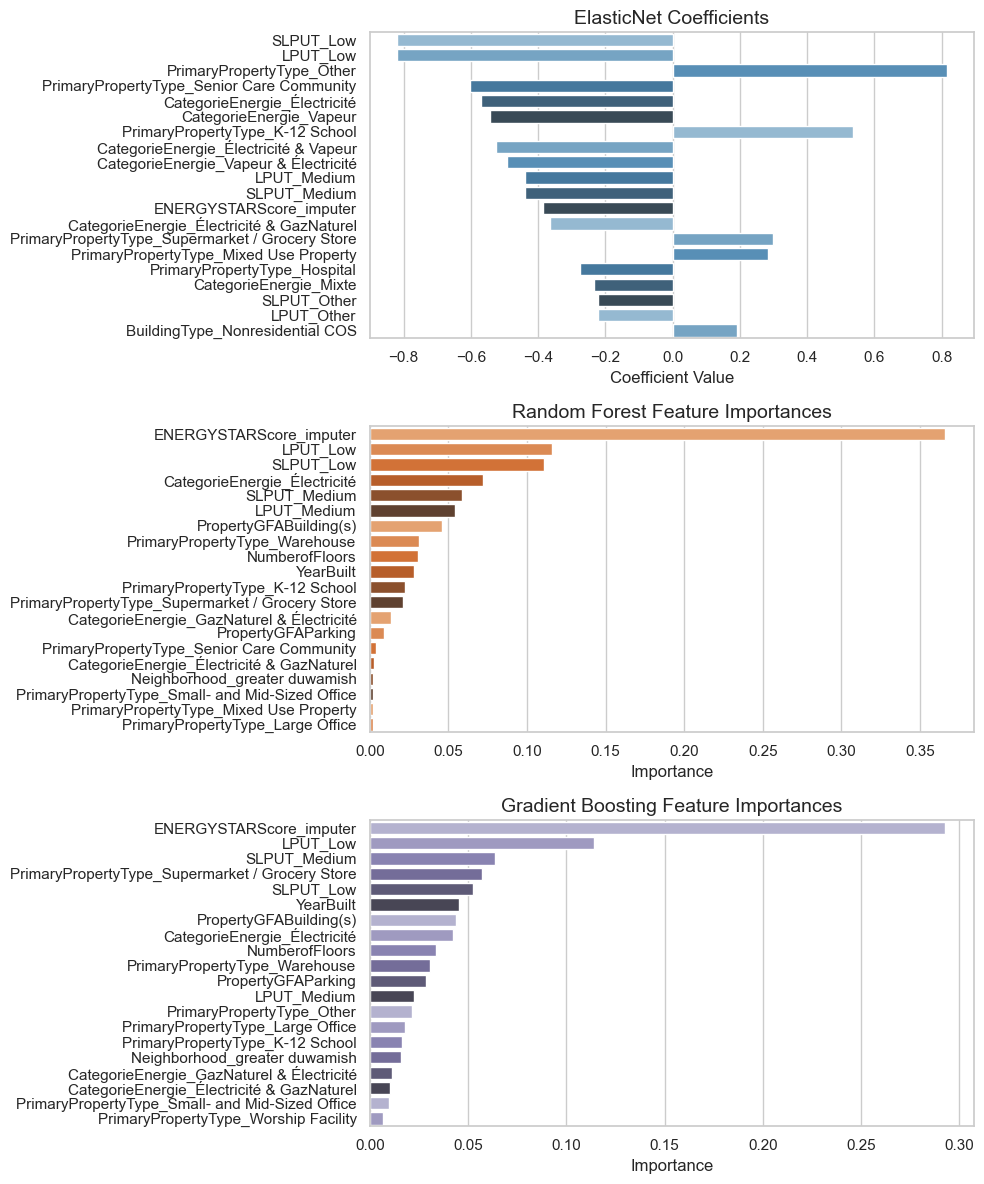

In [23]:
coef_en = pd.Series(best_model_en.coef_, index=X_train.columns)
coef_rf = pd.Series(best_rf.feature_importances_, index=X_train.columns)
coef_gb = pd.Series(best_gb.feature_importances_, index=X_train.columns)


# Créons des 15 plus grands coefficients en valeur absolue pour ElasticNet
coef_en = pd.Series(coef_en,index=X_train.columns).sort_values(key=abs, ascending=False)[:20]

# Et des 15 plus grandes importances de caractéristiques pour les deux autres modèles
importance_rf_top15 = pd.Series(coef_rf, index=X_train.columns).sort_values(ascending=False)[:20]
importance_gb_top15 = pd.Series(coef_gb, index=X_train.columns).sort_values(ascending=False)[:20]

# Réglons la figure pour visualiser les trois ensembles de données
fig, axs = plt.subplots(3, 1, figsize=(10, 12))

# ElasticNet
sns.barplot(x=coef_en.values, y=coef_en.index, ax=axs[0], palette=sns.color_palette("Blues_d"))
axs[0].set_title('ElasticNet Coefficients')
axs[0].set_xlabel('Coefficient Value')

# Random Forest
sns.barplot(x=importance_rf_top15.values, y=importance_rf_top15.index, ax=axs[1], palette=sns.color_palette("Oranges_d"))
axs[1].set_title('Random Forest Feature Importances')
axs[1].set_xlabel('Importance')

# Gradient Boosting
sns.barplot(x=importance_gb_top15.values, y=importance_gb_top15.index, ax=axs[2], palette=sns.color_palette("Purples_d"))
axs[2].set_title('Gradient Boosting Feature Importances')
axs[2].set_xlabel('Importance')

# Ajustement des marges entre les graphiques et affichage de la figure
plt.tight_layout()
plt.show()

## **5. Interprétation: SHAP et LIME**

### Identification des erreurs de prédiction pour RF et GB
Nous créons des datasets des erreurs de prédiction pour les modèles Random Forest et Gradient Boosting.

In [24]:
# création d'un dataset avec les erreurs les plus importantes du modèle
Err_gb = pd.DataFrame({'Erreur': np.abs(y_test.squeeze() - y_pred_optimized_gb)}, index=y_test.index)
Err_gb['Real Values'] = y_test.squeeze()
Err_gb['Predicted Values'] = y_pred_optimized_gb
Err_gb = Err_gb.sort_values('Erreur', ascending=False)
Err_gb.head(10)


,Erreur,Real Values,Predicted Values
1139,143.589831,149.100006,292.689837
1270,115.692290,107.699997,223.392286
1319,92.922476,301.899994,208.977518
834,88.718834,228.399994,139.681160
629,76.116059,57.400002,133.516061
910,72.279999,311.100006,238.820007
752,67.927411,18.500000,86.427411
578,61.645653,23.000000,84.645653
1133,59.859396,260.700012,320.559409
1219,59.015208,108.199997,49.184789


In [25]:
# création d'un dataset avec les erreurs les plus importantes du modèle
Err_rf = pd.DataFrame({'Erreur': np.abs(y_test.squeeze() - y_pred_optimized_series_rf)}, index=y_test.index)
Err_rf['Real Values'] = y_test.squeeze()
Err_rf['Predicted Values'] = y_pred_optimized_series_rf
Err_rf = Err_rf.sort_values('Erreur', ascending=False)
Err_rf.head(10)

,Erreur,Real Values,Predicted Values
103,123.811771,293.200012,169.388241
1139,123.001058,149.100006,272.101064
752,95.380797,18.500000,113.880797
629,89.701679,57.400002,147.101681
976,86.937130,207.500000,120.562870
1410,68.232679,123.900002,55.667323
578,58.652070,23.000000,81.652070
1219,58.190977,108.199997,50.009020
348,57.439396,291.500000,234.060604
298,56.248582,0.000000,56.248582


### SHAP

In [26]:
import shap

#### Waterfall d'instances remarquable
Nous utilisons SHAP pour visualiser l'impact des variables sur les prédictions pour des instances spécifiques.

Random Forest - SHAP values for original index 1139


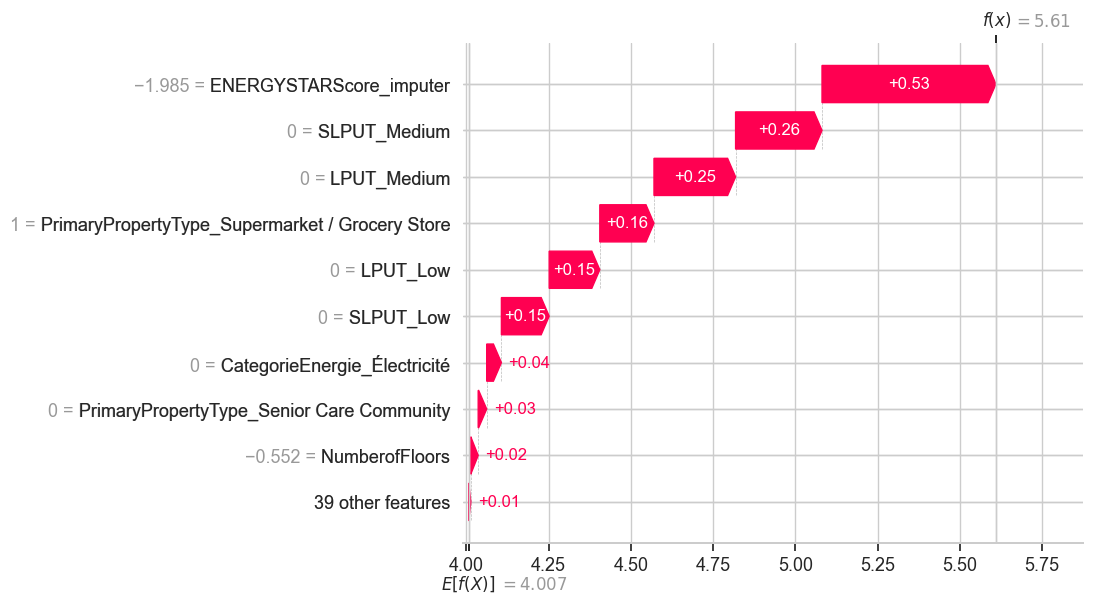

Gradient Boosting - SHAP values for original index 1139


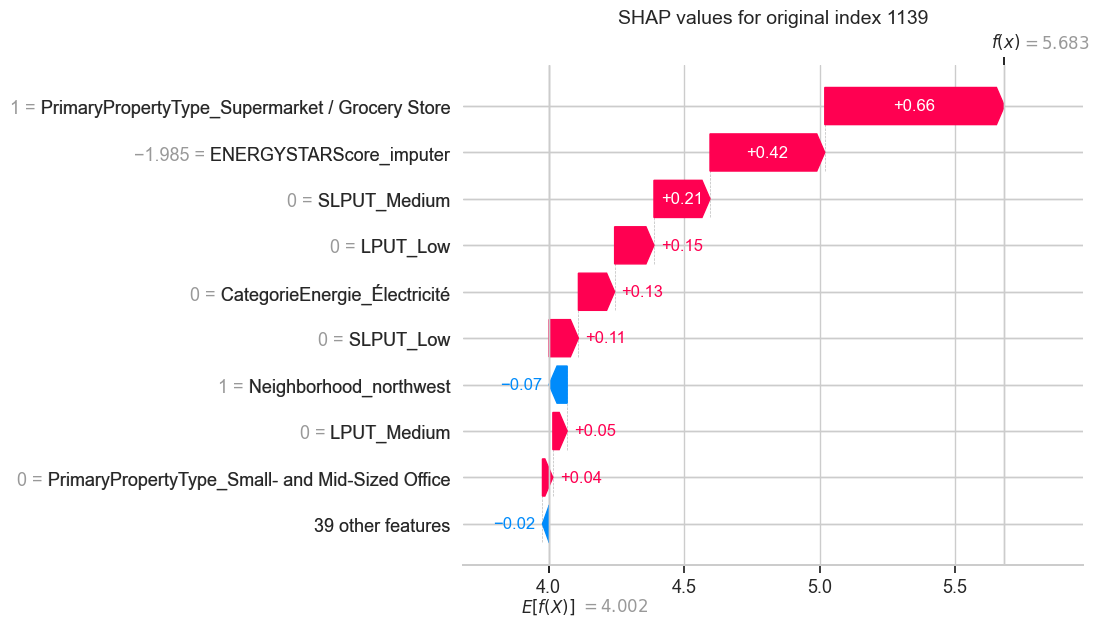

Random Forest - SHAP values for original index 103


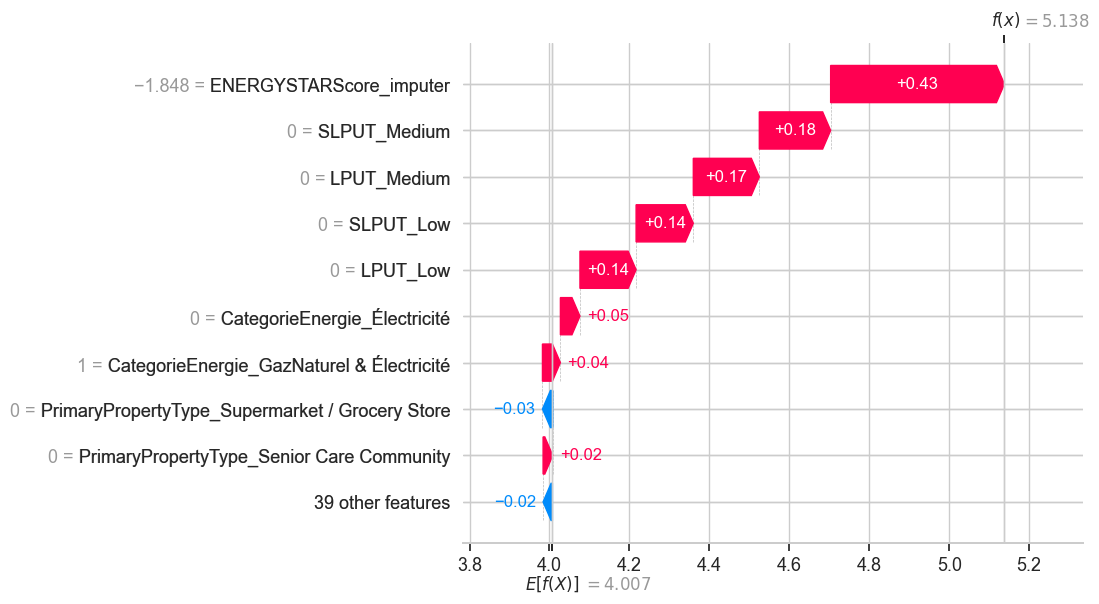

Gradient Boosting - SHAP values for original index 103


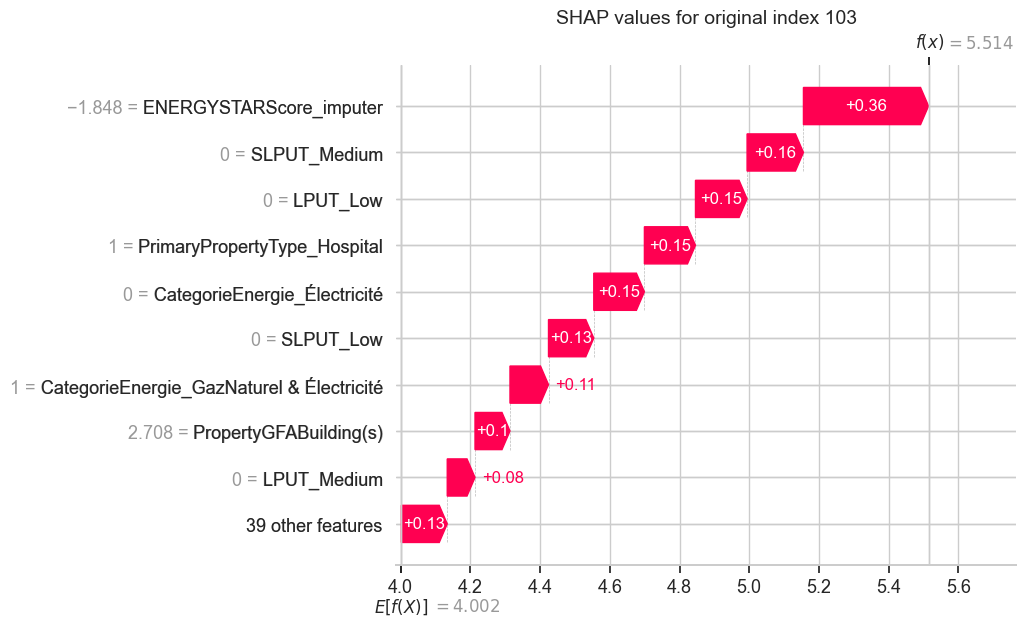

Random Forest - SHAP values for original index 349


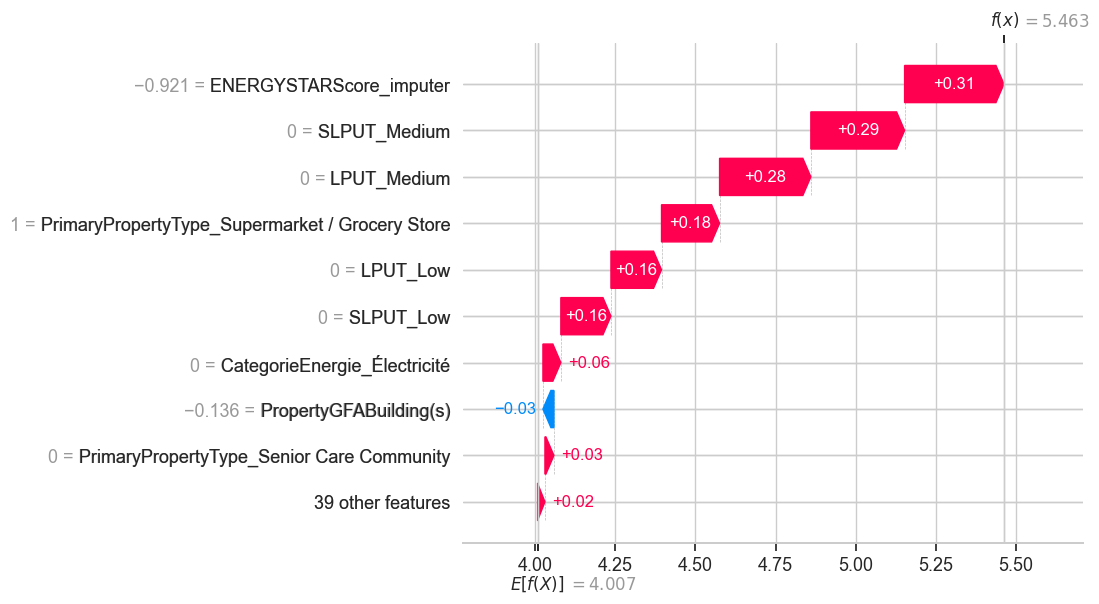

Gradient Boosting - SHAP values for original index 349


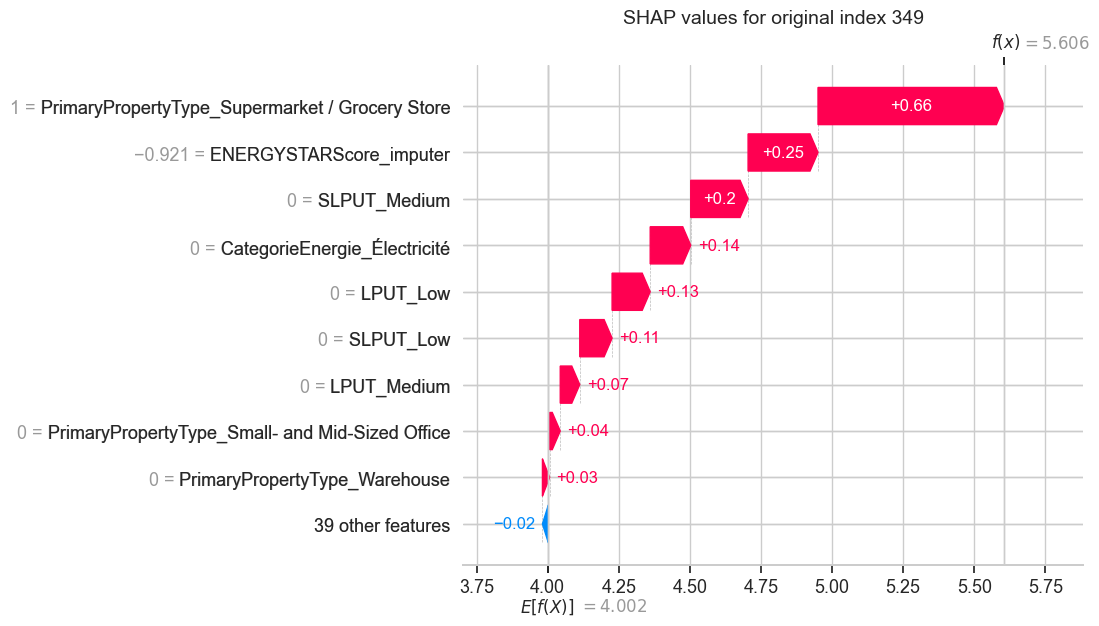

In [27]:
# Supposons que best_rf et best_gb sont vos modèles entraînés Random Forest et Gradient Boosting
explainer_rf = shap.TreeExplainer(best_rf)
explainer_gb = shap.TreeExplainer(best_gb)

# Calcul des valeurs SHAP pour l'ensemble de test
shap_values_rf = explainer_rf.shap_values(X_test)
shap_values_gb = explainer_gb.shap_values(X_test)

# Liste des indices à comparer
indices_to_compare = [1139, 103, 349]

# Convertir les indices en positions dans X_test
positions_to_compare = [X_test.index.get_loc(idx) for idx in indices_to_compare if idx in X_test.index]

# Affichage des valeurs SHAP pour chaque indice et chaque modèle
for i, position in enumerate(positions_to_compare):
    original_index = indices_to_compare[i]

    # Création de l'objet Explanation pour l'instance spécifique avec Random Forest
    shap_values_instance_rf = shap.Explanation(values=shap_values_rf[position],
                                               base_values=explainer_rf.expected_value,
                                               data=X_test.iloc[position],
                                               feature_names=X_test.columns.tolist())
    print(f"Random Forest - SHAP values for original index {original_index}")
    shap.waterfall_plot(shap_values_instance_rf)

    # Création de l'objet Explanation pour l'instance spécifique avec Gradient Boosting
    shap_values_instance_gb = shap.Explanation(values=shap_values_gb[position],
                                               base_values=explainer_gb.expected_value,
                                               data=X_test.iloc[position],
                                               feature_names=X_test.columns.tolist())
    print(f"Gradient Boosting - SHAP values for original index {original_index}")
    shap.waterfall_plot(shap_values_instance_gb, show=False)
    plt.title(f"SHAP values for original index {original_index}")
    plt.show()


#### Summary Plot
Nous utilisons les summary plots de SHAP pour visualiser l'importance globale des variables.

In [28]:
# Explainer pour chaque modèle
explainer_en = shap.LinearExplainer(best_model_en, X_train)
#explainer_svr = shap.KernelExplainer(best_svr.predict, X_train)
explainer_rf = shap.TreeExplainer(best_rf)
explainer_gb = shap.TreeExplainer(best_gb)

# Shape values pour chaque modèle
shap_values_en = explainer_en.shap_values(X_test)
#shap_values_svr = explainer_svr.shap_values(X_test)
shap_values_rf = explainer_rf.shap_values(X_test)
shap_values_gb = explainer_gb.shap_values(X_test)

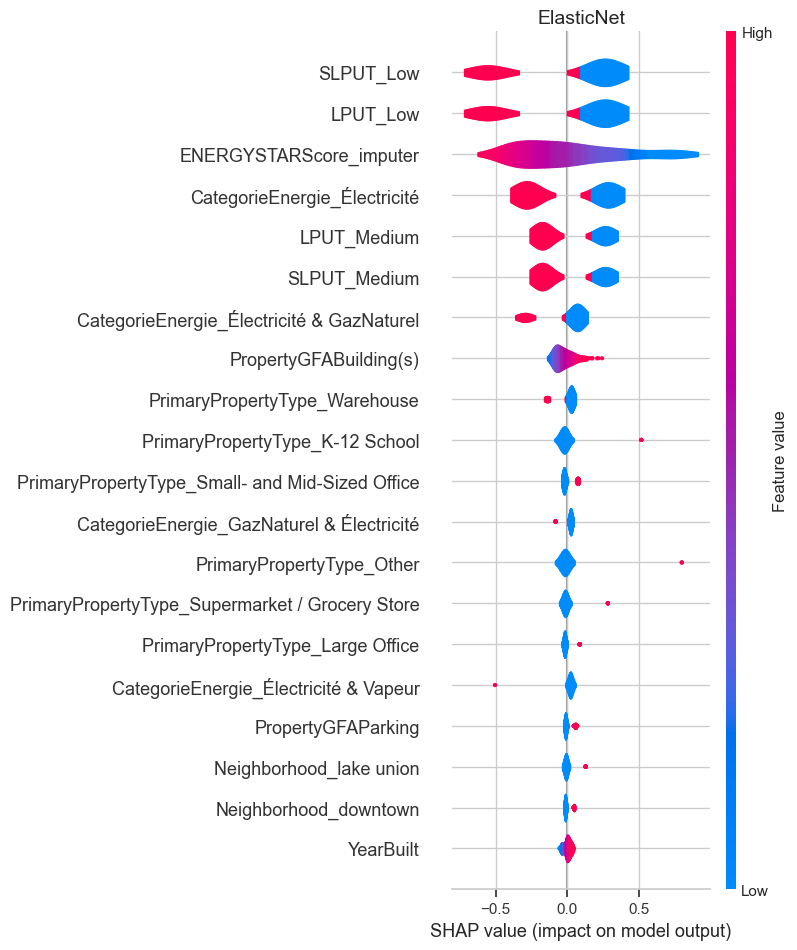

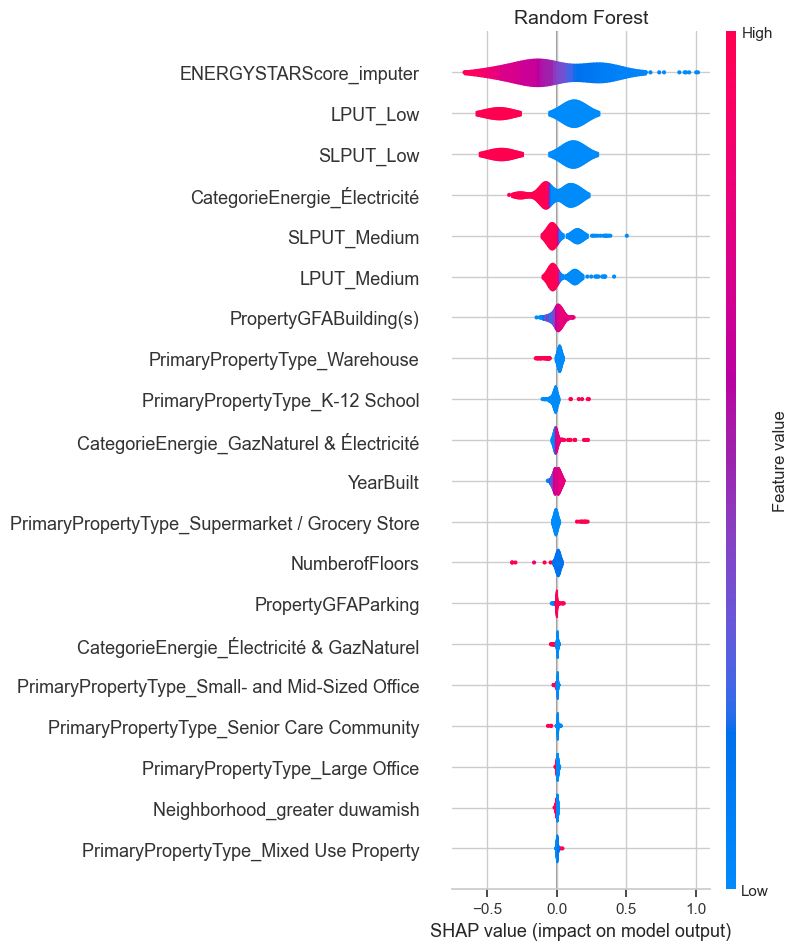

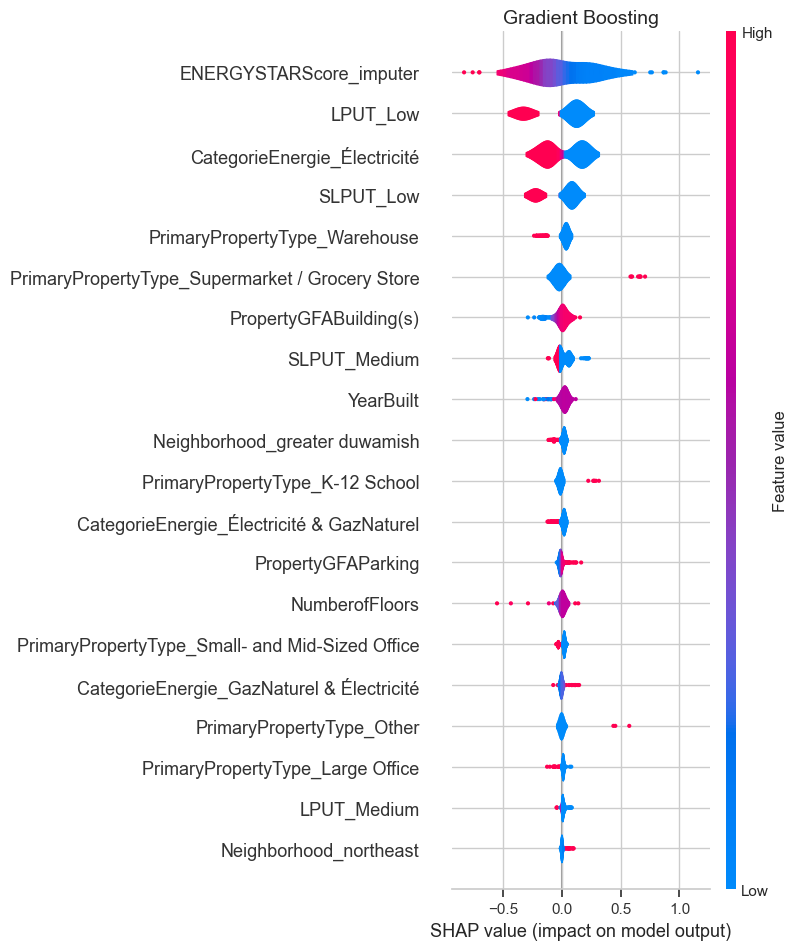

In [29]:
# Création d'un objet shap.summary_plot pour chaque modèle
shap.summary_plot(shap_values_en, X_test, plot_type="violin", show=False)
plt.title('ElasticNet')
plt.show()

#shap.summary_plot(shap_values_svr, X_test, plot_type="violin", show=False)
#plt.title('SVM')
#plt.show()

shap.summary_plot(shap_values_rf, X_test, plot_type="violin", show=False)
plt.title('Random Forest')
plt.show()

shap.summary_plot(shap_values_gb, X_test, plot_type="violin", show=False)
plt.title('Gradient Boosting')
plt.show()

#### Embedding plot gb
Nous générons des graphiques d'incorporation pour des caractéristiques spécifiques sur l'ensemble du jeu de test.

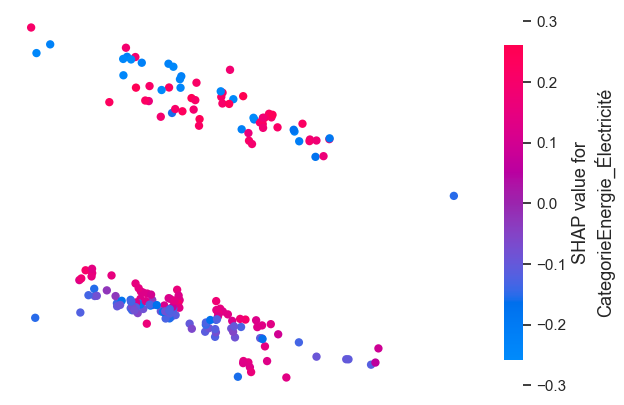

In [30]:
# Initialiser l'explainer avec le modèle Random Forest
explainer = shap.TreeExplainer(best_gb)
# Calculer les valeurs SHAP pour le jeu de test complet
shap_values_full = explainer.shap_values(X_test)

# Générez un graphique d'incorporation pour la caractéristique spécifique sur l'ensemble du jeu de test
shap.embedding_plot("CategorieEnergie_Électricité", shap_values_full, feature_names=X_test.columns.tolist())

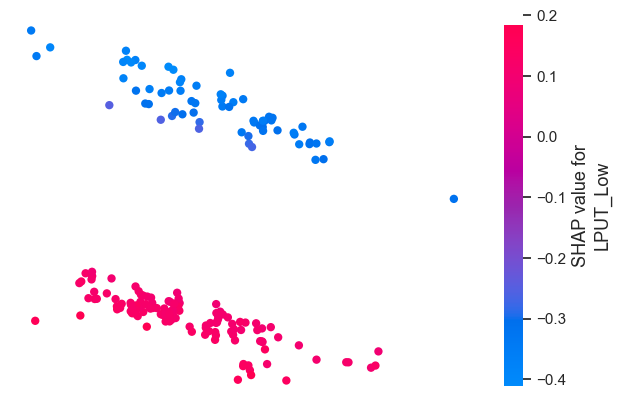

In [31]:
# Calculer les valeurs SHAP pour le jeu de test complet
shap_values_full = explainer.shap_values(X_test)

# Générez un graphique d'incorporation pour la caractéristique spécifique sur l'ensemble du jeu de test
shap.embedding_plot('LPUT_Low', shap_values_full, feature_names=X_test.columns.tolist())


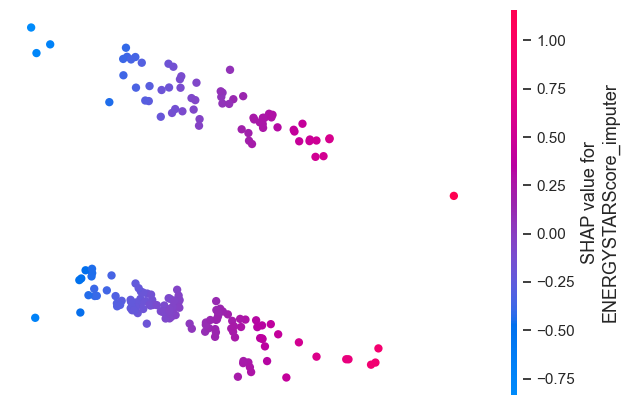

In [32]:
# Initialiser l'explainer avec le modèle Random Forest
explainer = shap.TreeExplainer(best_gb)
# Calculer les valeurs SHAP pour le jeu de test complet
shap_values_full = explainer.shap_values(X_test)

# Générez un graphique d'incorporation pour la caractéristique spécifique sur l'ensemble du jeu de test
shap.embedding_plot("ENERGYSTARScore_imputer", shap_values_full, feature_names=X_test.columns.tolist())

### Influence des variables en fonction de la valeur de la variable cible
Nous analysons l'influence des variables sur la prédiction en séparant les données en deux groupes selon leurs valeurs réelles (supérieures ou inférieures à 200).

In [33]:
# séparation des données en deux groupes valeurs réelles supérieures à 200 et inférieures à 200
Err_rf_sup200 = Err_rf[Err_rf['Real Values'] > 200]
Err_rf_inf200 = Err_rf[Err_rf['Real Values'] <= 200]

Err_gb_sup200 = Err_gb[Err_gb['Real Values'] > 200]
Err_gb_inf200 = Err_gb[Err_gb['Real Values'] <= 200]

Err_rf_sup200.shape, Err_rf_inf200.shape, Err_gb_sup200.shape, Err_gb_inf200.shape

((10, 3), (190, 3), (10, 3), (190, 3))

In [34]:
# reccupération des index des différents groupes
index_rf_sup200 = Err_rf_sup200.index
index_rf_inf200 = Err_rf_inf200.index
index_gb_sup200 = Err_gb_sup200.index
index_gb_inf200 = Err_gb_inf200.index

In [35]:
for i in index_gb_sup200:
    print("la valeur réelle de l'index", i, "est", Err_gb.loc[i, 'Real Values'], "et la valeur prédite est", Err_gb.loc[i, 'Predicted Values'])

la valeur réelle de l'index 1319 est 301.8999939 et la valeur prédite est 208.97751816739083
la valeur réelle de l'index 834 est 228.3999939 et la valeur prédite est 139.68116020305283
la valeur réelle de l'index 910 est 311.1000061 et la valeur prédite est 238.82000725469234
la valeur réelle de l'index 1133 est 260.7000122 et la valeur prédite est 320.55940864613234
la valeur réelle de l'index 976 est 207.5 et la valeur prédite est 150.6710452385803
la valeur réelle de l'index 348 est 291.5 et la valeur prédite est 242.82812671630305
la valeur réelle de l'index 103 est 293.2000122 et la valeur prédite est 247.2586011785297
la valeur réelle de l'index 394 est 249.1999969 et la valeur prédite est 280.04068182250745
la valeur réelle de l'index 1317 est 303.2000122 et la valeur prédite est 275.1085713285193
la valeur réelle de l'index 349 est 254.6000061 et la valeur prédite est 271.04498928465057


In [36]:
import shap
explainer_rf = shap.TreeExplainer(best_rf)
explainer_gb = shap.TreeExplainer(best_gb)

shape_values_rf_inf = explainer_rf.shap_values(X_test.loc[index_rf_inf200])
shape_values_rf_sup = explainer_rf.shap_values(X_test.loc[index_rf_sup200])
shape_values_gb_inf = explainer_gb.shap_values(X_test.loc[index_gb_inf200])
shape_values_gb_sup = explainer_gb.shap_values(X_test.loc[index_gb_sup200])


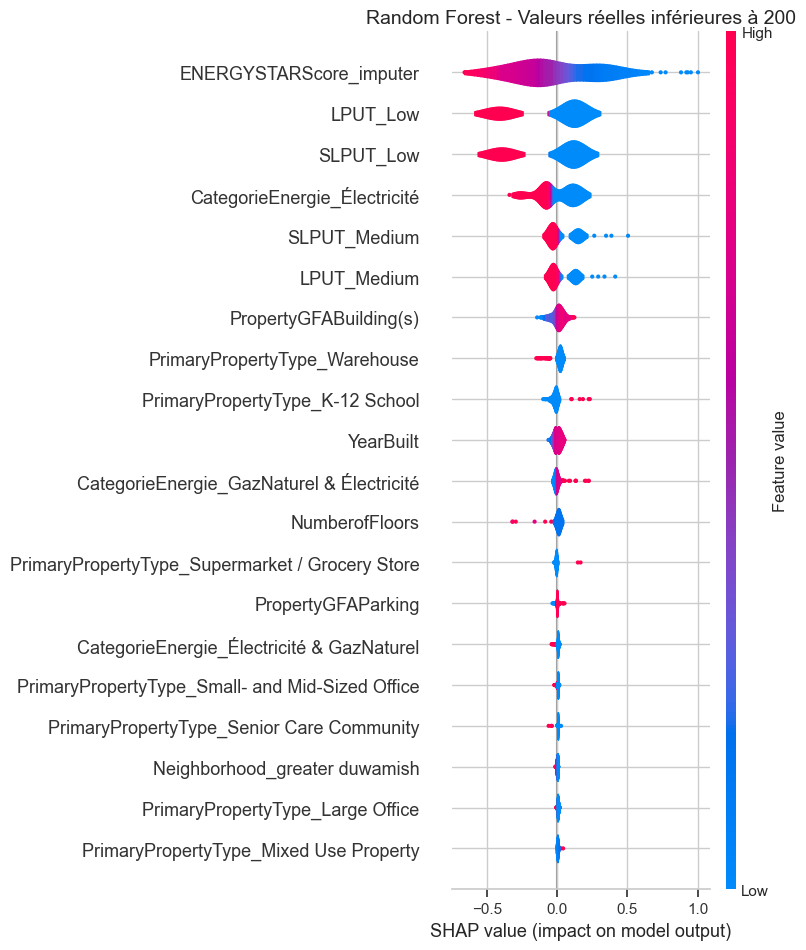

In [37]:
shap.summary_plot(shape_values_rf_inf, X_test.loc[index_rf_inf200], plot_type="violin", max_display=20, show=False)
plt.title('Random Forest - Valeurs réelles inférieures à 200')
plt.show()

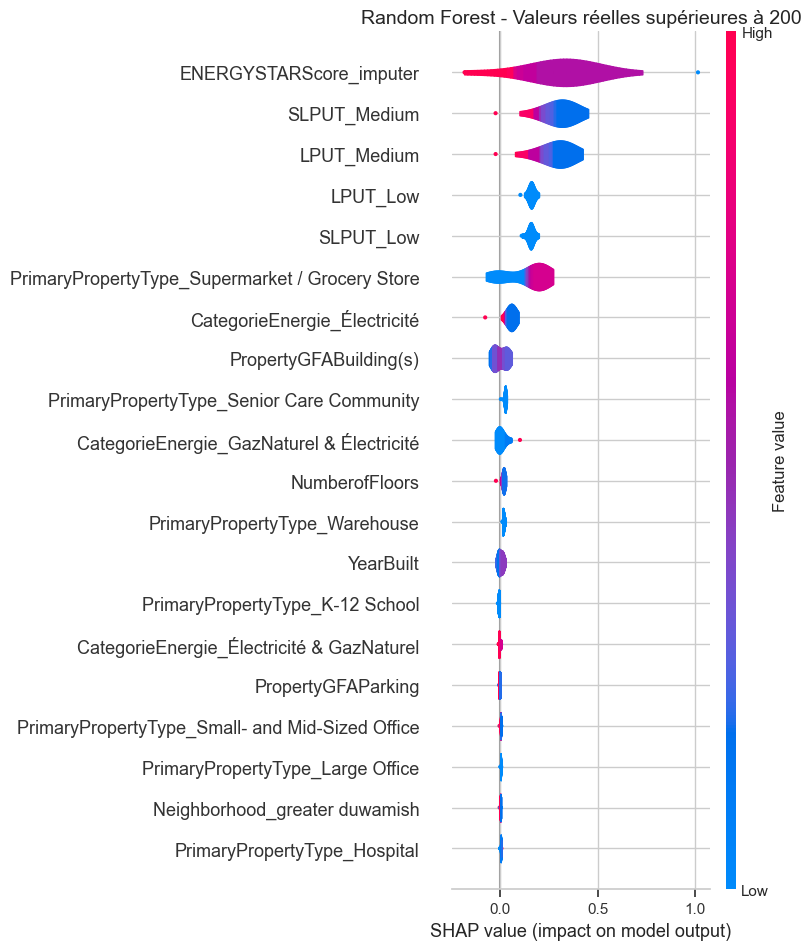

In [38]:

shap.summary_plot(shape_values_rf_sup, X_test.loc[index_rf_sup200], plot_type="violin", max_display=20, show=False)
plt.title('Random Forest - Valeurs réelles supérieures à 200')
plt.show()


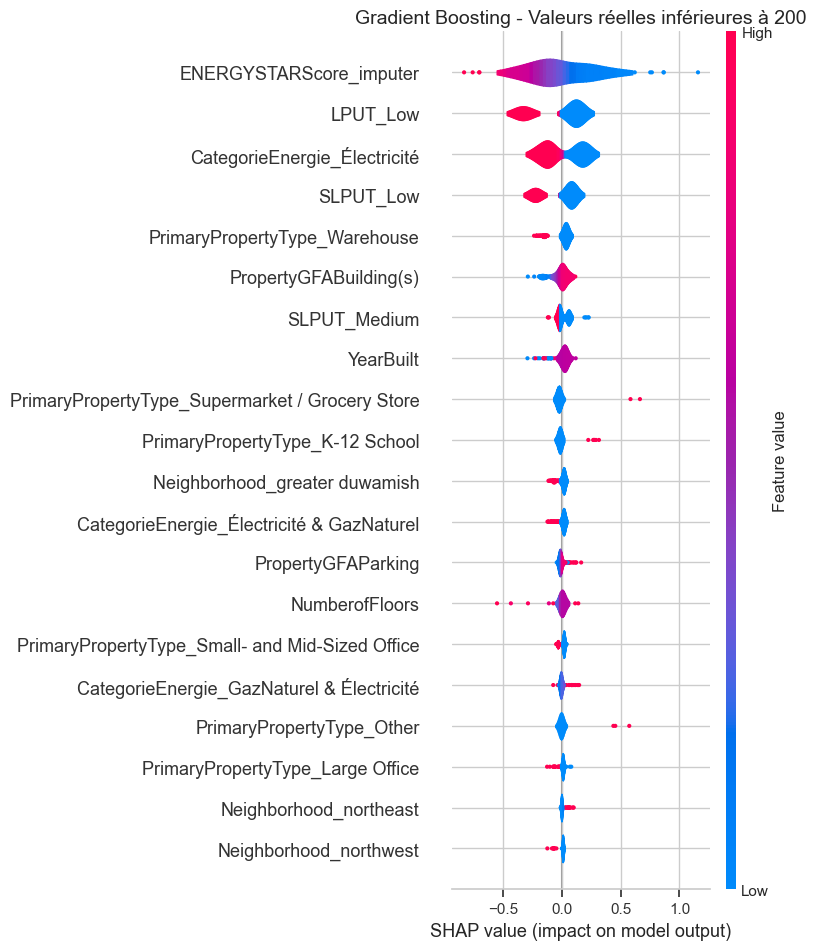

In [39]:

shap.summary_plot(shape_values_gb_inf, X_test.loc[index_gb_inf200], plot_type="violin", max_display=20, show=False)
plt.title('Gradient Boosting - Valeurs réelles inférieures à 200')
plt.show()


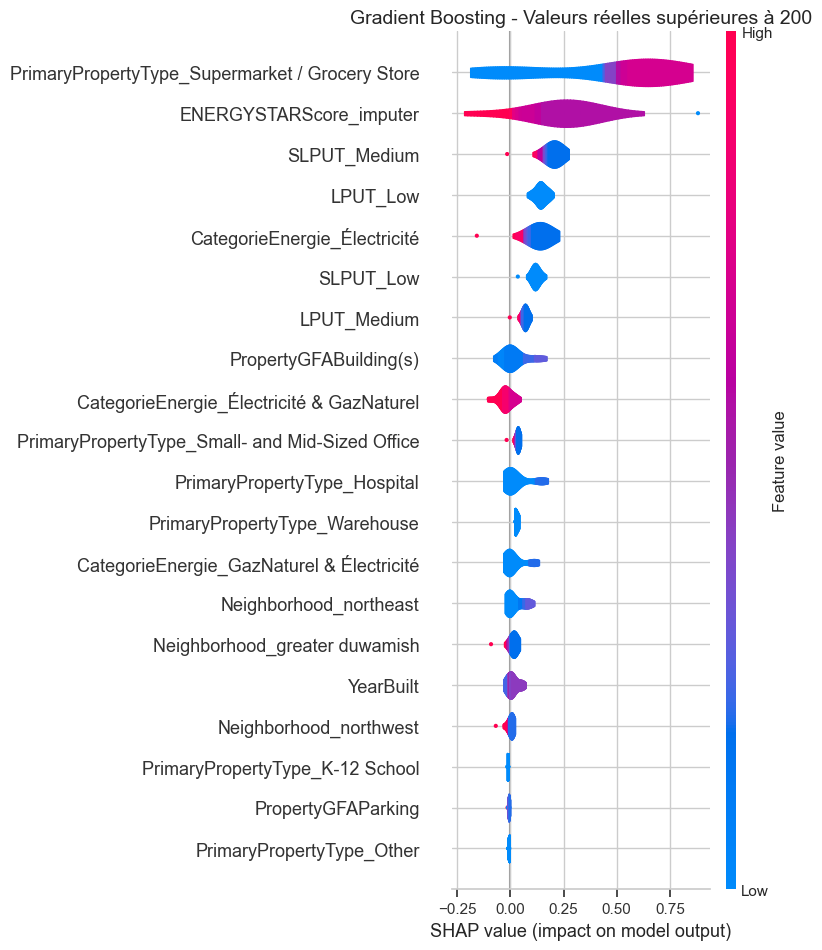

In [40]:

shap.summary_plot(shape_values_gb_sup, X_test.loc[index_gb_sup200], plot_type="violin", max_display=20, show=False)
plt.title('Gradient Boosting - Valeurs réelles supérieures à 200')
plt.show()